# Домашнее задание 5

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1 (10 pts)

Пусть задан набор из $N$ пар точек в $n$-мерном пространстве $x_1, \ldots , x_N$ и $y_1, \ldots, y_N$.
Также даны расстояния $d_1, \ldots , d_N$ между ними. Необходимо найти такую матрицу $M \in \mathbb{S}^n_+$, что 
$d_i \approx d(x_i, y_i) = \sqrt{(x_i − y_i)M(x_i − y_i)}$. 
Таким образом, целевой функцией в
данной задаче является следующая функция
$$ 
\min_{M \in \mathbb{S}^n_+} \frac{1}{N}\sum_{i=1}^N (d_i - d(x_i, y_i))^2.
$$

В данном случае при старте из точки $M_0 \in \mathbb{S}^n_+$ тестируемые методы не должен выводить промежуточные точки $M_k$ за границы допустимого множества, но не забудьте это проверять и модифицируйте размер шага соответственно.

Сравните сходимость градиентного спуска, метода тяжёлого шарика и быстрого градиентного метода для решения этой задачи.

Также проверьте ошибку на тестовых данных ```d_test, X_test, Y_test```. Прокомментируйте результат.

In [39]:
from scipy import linalg as la
import numpy as np
np.random.seed(8)

n = 5 # Dimension
N = 100 # Number of sample
N_test = 10 # Samples for test set

X = np.random.randn(n,N)
Y = np.random.randn(n,N)

X_test = np.random.randn(n,N_test)
Y_test = np.random.randn(n,N_test)

P = np.random.randn(n,n)
P = P.dot(P.T) + np.identity(n)
sqrtP = la.sqrtm(P)

d = np.linalg.norm(sqrtP.dot(X-Y),axis=0)
d = np.maximum(d+np.random.randn(N),0)
d_test = np.linalg.norm(sqrtP.dot(X_test-Y_test),axis=0)
d_test = np.maximum(d_test+np.random.randn(N_test),0)

In [40]:
import time
import matplotlib
import matplotlib.pyplot as plt

In [41]:
#Генерируем начальную точку
A0 = np.random.randn(n,n)
A0 = A0.dot(A0.T) + np.identity(n)

In [42]:
#Скалярное произведение
def func1(x, A):
    f = np.matmul(x.T, A)
    f = np.matmul(f, x)
    return np.sqrt(f.diagonal())

In [43]:
#d_i{x_i,y_i}
def func(x, A, d):
    f = func1(x, A)
    return np.mean((f - d) ** 2)

In [44]:
#Градиент функции, которую минимизируем
def grad(x, A, d):
    f = func1(x,A)
    grad = np.zeros(A.shape)
    for i in range(x.shape[1]):
        grad += (f[i] - d[i]) * np.outer(x[:,i], x[:,i]) / f[i]
    return grad / x.shape[1]

In [45]:
#Градиентный спуск
def gd(grad, A0, num_iter, tol, alpha,x,d):
    A = A0.copy()
    conv = [A0.copy()]
    for i in range(num_iter):
        g = grad(x,A,d)
        A = A - alpha * g
        conv.append(A.copy())
        if np.linalg.norm(g,'fro') < tol:
            break
    return A, conv

In [46]:
#тяжелый шарик
def hb(grad, A0, num_iter, tol, alpha, beta,x,d):
    A = A0.copy()
    conv = [A0.copy()]
    A_prev = A0.copy()
    for i in range(num_iter):
        g = grad(x, A, d)
        if np.linalg.norm(g, 'fro') < tol:
            conv.append(A.copy())
            break
        if i == 0:
            A = A - alpha * g
            conv.append(A.copy())
        else:
            A = A - alpha * g + beta * (A - conv[-2])
            conv.append(A.copy())
    return A, conv

In [47]:
#Нестеров
def Nesterov(grad, A0, num_iter, tol, alpha, x, d):
    A = A0.copy()
    conv = [A0.copy()]
    A_prev = A0.copy()
    k = 0
    y = A0.copy()
    while k == 0 or np.linalg.norm(grad(x, y, d)) > tol: 
        A_prev, A = A, y - alpha * grad(x, y, d)
        y = A + k/(k+3) * (A - A_prev)
        conv.append(A)
        if k >= num_iter:
            break
        k += 1
    return A, conv

In [48]:
#Запуск градиентного спуска
#Проведем небольшой перебор параметров. Возьмем alpha = 1,2 и 3 и проверим
A_1, conv_1 = gd(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 1, x = (X - Y), d = d)
A_2, conv_2 = gd(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 2, x = (X - Y), d = d)
A_3, conv_3 = gd(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 2, x = (X - Y), d = d)

In [49]:
#Запуск тяжелого шарика
A_hb_1, conv_hb_1 = hb(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 1, beta = 0.4, x = (X - Y), d = d)
A_hb_2, conv_hb_2 = hb(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 2, beta = 0.4, x = (X - Y), d = d)
A_hb_3, conv_hb_3 = hb(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 3, beta = 0.4, x = (X - Y), d = d)

In [50]:
#Запуск Нестерова
A_n_1, conv_n_1 = Nesterov(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 1, x = (X - Y), d = d)
A_n_2, conv_n_2 = Nesterov(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 2, x = (X - Y), d = d)
A_n_3, conv_n_3 = Nesterov(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 3, x = (X - Y), d = d)

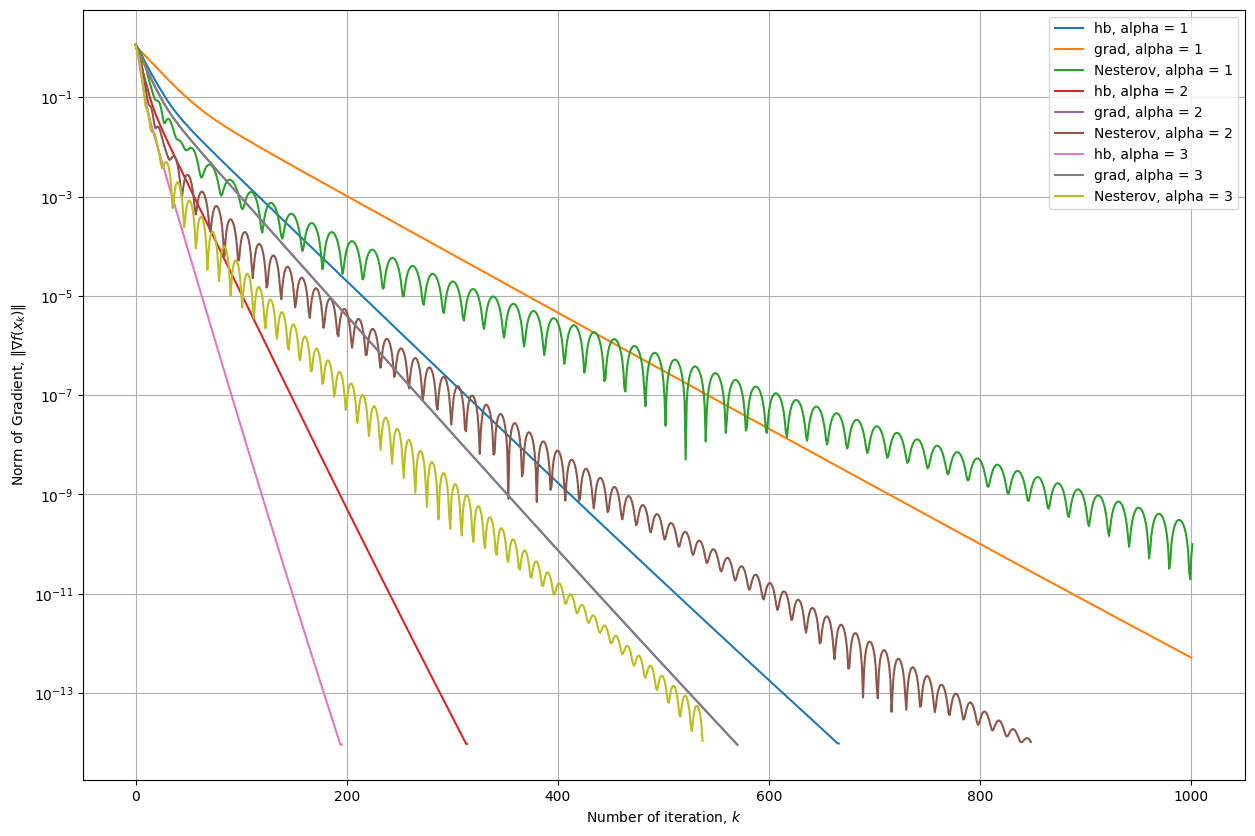

In [51]:
#Рисуем графики значения функции
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_hb_1],label = 'hb, alpha = 1')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_1],label = 'grad, alpha = 1')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_n_1],label = 'Nesterov, alpha = 1')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_hb_2],label = 'hb, alpha = 2')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_2],label = 'grad, alpha = 2')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_n_2],label = 'Nesterov, alpha = 2')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_hb_3],label = 'hb, alpha = 3')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_3],label = 'grad, alpha = 3')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_n_3],label = 'Nesterov, alpha = 3')
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.yscale('log')

У метода тяжелого шарика есть ещё параметр $\beta$. Давайте возьмем фиксированный $\alpha = 3$(так как он показал себя лучше всего и проверим, какие $\beta$ лучше всего подходят

In [52]:
#Запуск тяжелого шарика
A_hb_1, conv_hb_1 = hb(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 3, beta = 0.2, x = (X - Y), d = d)
A_hb_2, conv_hb_2 = hb(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 3, beta = 0.4, x = (X - Y), d = d)
A_hb_3, conv_hb_3 = hb(grad = grad, A0 = A0, num_iter = 1000, tol = 1e-14, alpha = 3, beta = 0.6, x = (X - Y), d = d)

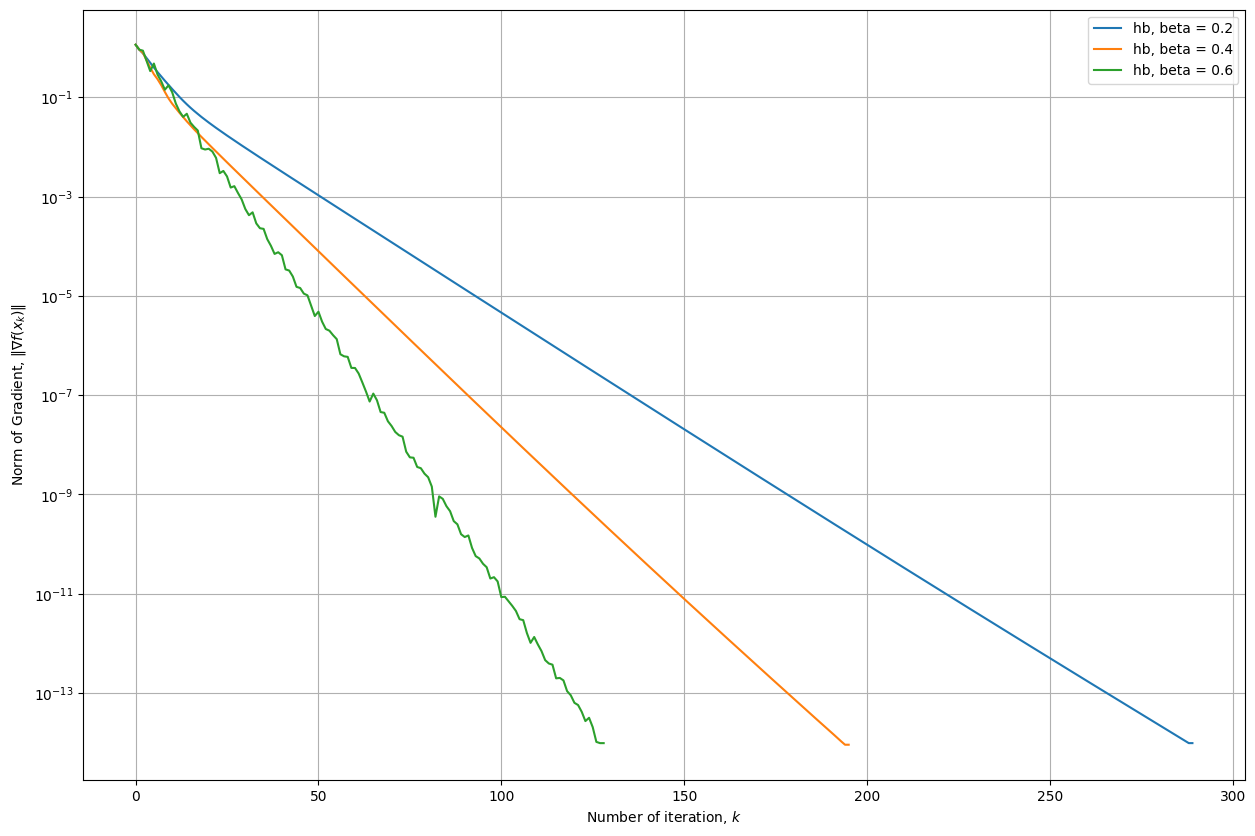

In [53]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_hb_1],label = 'hb, beta = 0.2')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_hb_2],label = 'hb, beta = 0.4')
plt.plot([np.linalg.norm(grad(X - Y, i, d),'fro') for i in conv_hb_3],label = 'hb, beta = 0.6')
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.yscale('log')

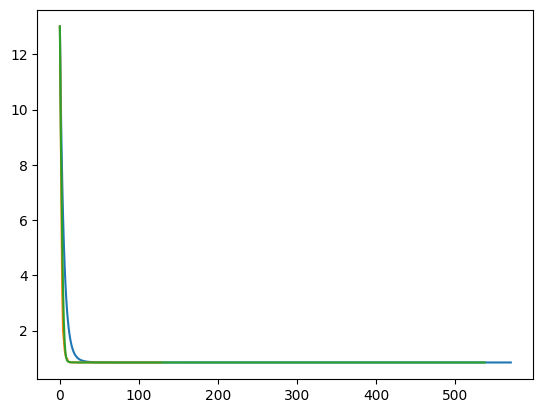

In [54]:
#Рисуем графики значения целевой функции
plt.plot([func(X - Y, i, d) for i in conv_3],label = 'func_gd')
plt.plot([func(X - Y, i, d) for i in conv_hb_3],label = 'func_hd')
plt.plot([func(X - Y, i, d) for i in conv_n_3],label = 'func_hd')

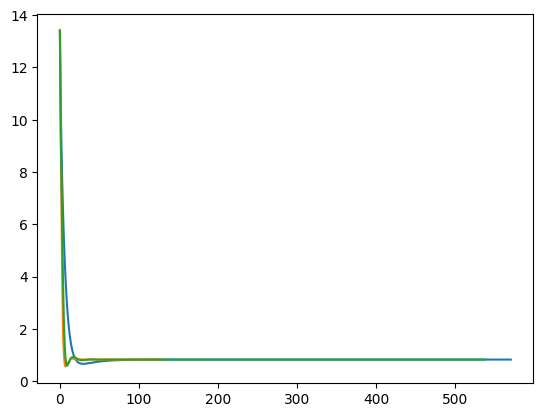

In [55]:
#Рисуем графики значения функции на тестовой выборке
plt.plot([func(X_test - Y_test, i, d_test) for i in conv_3],label = 'func_gd')
plt.plot([func(X_test - Y_test, i, d_test) for i in conv_hb_3],label = 'func_hd')
plt.plot([func(X_test - Y_test, i, d_test) for i in conv_n_3],label = 'func_hd')

In [56]:
#Значения на тестовой выборке градиентво с последней итерации
print(func(X_test - Y_test, conv_3[-1], d_test))
print(func(X_test - Y_test, conv_hb_3[-1], d_test))
print(func(X_test - Y_test, conv_n_3[-1], d_test))

0.8234982883026711
0.8234982883027199
0.8234982883026725


## Задача 2 (10 pts)

- (2 pts) Покажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

- (5 pts) Докажите, что если целевая функция $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, шаг определяется с помощью наискорейшего спуска и $x^0 - x^*$ параллелен собственному вектору матрицу $Q$, то градиентный спуск сходится за один шаг. 

- Покажите, что для $f(x) = x^{\top}x$ градиентный спуск с выбором шага по правилу наискорейшего спуска сходится за одну итерацию:
    - (1 pts) с использованием предыдущего утверждения
    - (2 pts) прямым вычислением 

## Решение

## 1

$x_{n+1} = f(x_n - \alpha\nabla f(x_n))$, где $\alpha = argmin_{\alpha}(f(x_n - \alpha\nabla f(x_n))$

Найдем $argmin$

Так как $f$ дифференцируемо, то минимум будет в точке, где производная по $\alpha$ функции $f$ равна 0

$[f(x_n - \alpha\nabla f(x_n))]'_{\alpha} = \nabla f(x_n - \alpha\nabla f(x_n))^{\top}(-\nabla f(x_n)) = 0$

Но $x_{n+1} = x_n - \alpha\nabla f(x_n)$, т.е $\nabla f(x_{n+1})^{\top}\nabla f(x_n) = 0$

## 2

Пусть $x'$ - собственный вектор матрицы $Q$ с собственным значением $\lambda$

Так как $Q \in S^{n}_{++}$, то функция выпуклая, а её минимальное значение находится в точке $x^* = Q^{-1}b$, а градиент функции равен $Qx - b$

Тогда по условию, $x_0 = x^* + px$

$x_1 = x_0 - \alpha (Qx_0 -b) = Q^{-1}b + px - \alpha(Q(Q^{-1}b + px) - b) = Q^{-1}b + px -\alpha(b + pQx - b) = Q^{-1}b + px - \alpha\lambda px = Q^{-1}b + px(1 - \alpha\lambda)$

Т.е, при {$\large\alpha = \frac{1}{\lambda}$} мы сразу достигнем минимума

## 3

$I \in S^{n}_{++}$, также для единичной матрицы любой вектор будет собственным. Поэтому по утверждению грдиентный спуск сходится за 1 шаг. Т.е $x_0 -$ собственный вектор для $I$, 0 - точка минимума, т.е $x_0 - x^* = x_0 -$ параллелен(даже совпадает) с собственным вектором

## 4

$x_1 = argmin((x_0 - 2\alpha x_0)^{\top}(x_0 - 2\alpha x_0))$

$(x_0 - 2\alpha x_0)^{\top}(x_0 - 2\alpha x_0) = x_0^{\top}x_0 - 4\alpha x_0^{\top}x_0 + 4\alpha^2 x_0^{\top}x_0$

производная по $\alpha$: $8\alpha x_0^{\top}x_0 - 4x_0^{\top}x_0 = 0$

$\alpha=0.5$. При $\alpha=0.5$ градиентный спуск доходит до минимума за 1 шаг

## Задача 3 (15 pts)

- (5 pts) Оцените константу Липшица градиента для функции

$$
f(w) = \frac12 \|w\|_2^2 + C \frac1m \sum_{i=1}^m \log (1 + \exp(- y_i \langle x_i, w \rangle)) \to \min_w
$$

- (10 pts) Используя найденное значение сравните сходимость метода тяжёлого шарика, метод градиентного спуска с оптимальным постоянным шагом и быстрый градиентный метод. Сделайте вывод о точности оценки констант и их влиянии на скорость сходимости метода тяжёлого шарика. Векторы $x_i$ и скаляры $y_i$ геенрируются кодом ниже.

In [58]:
n = 300
m = 1000
import sklearn.datasets as skldata

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

Оценим константу Липшица градиента функции
$$
\nabla f(w) = w + C\frac1m \sum_{i=1}^{m}{\frac{-y_ix_i\exp{(-y_i\langle x_i, w \rangle)}}{1 + \exp{(-y_i\langle x_i, w \rangle)}}} = w +  C\frac1m \sum_{i=1}^{m}{\frac{-y_ix_i}{1 + \exp{(y_i\langle x_i, w \rangle)}}}
$$

$\|\nabla{f(w_2)} - \nabla{f(w_1)}\|_2 = \|w_2 +  C\frac1m \sum_{i=1}^{m}{\frac{-y_ix_i}{1 + \exp{(y_i\langle x_i, w_2 \rangle)}}} - w_1 -  C\frac1m \sum_{i=1}^{m}{\frac{-y_ix_i}{1 + \exp{(y_i\langle x_i, w_1 \rangle)}}}\| \leq $

$\|w_2 - w_1\| + |C\frac1m \sum_{i=1}^{m}{\frac{-y_ix_i}{1 + \exp{(y_i\langle x_i, w_2 \rangle)}} - \frac{-y_ix_i}{1 + \exp{(y_i\langle x_i, w_1 \rangle)}}}| \leq \|w_2 - w_1\| + |C\frac1m|\sum_{i=1}^{m}{\|y_ix_i\||(\frac{1}{1 + \exp{(y_i\langle x_i, w_2 \rangle)}} - \frac{1}{1 + \exp{(y_i\langle x_i, w_1 \rangle)}})|}$

Оценим $|\frac{1}{1 + \exp{(y_i\langle x_i, w_2 \rangle)}} - \frac{1}{1 + \exp{(y_i\langle x_i, w_1 \rangle)}}|$

Пусть $F(t) = \frac{1}{1 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}}$. Таким образом $|\frac{1}{1 + \exp{(y_i\langle x_i, w_2 \rangle)}} - \frac{1}{1 + \exp{(y_i\langle x_i, w_1 \rangle)}}| = |F(1) - F(0)|$

$F - $ дифференцируемая на $[0;1]$, то по теореме Лагранжа $\exists { \xi},$ что $F(1) - F(0) = F'(\xi)(1 - 0) = F'(\xi)$, т.е $|F(1) - F(0)| = |F'(\xi)| \leq \max_{\xi \in [0;1]}|F'(\xi)|$

Производная $F = -\frac{\exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)*(y_i\langle x_i, w_2 - w_1 \rangle)}}{(1 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)})^2} = \frac{y_i\langle x_i, w_2 - w_1 \rangle)}{(1 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)})*(1 + \exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)})} = \frac{y_i\langle x_i, w_2 - w_1 \rangle)}{1 + 1 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)} + \exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}} = \frac{y_i\langle x_i, w_2 - w_1 \rangle)}{2 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)} + \exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}}$

Т.е $\max_{\xi \in [0;1]}|F'(\xi)| = \max |\frac{y_i\langle x_i, w_2 - w_1 \rangle)}{2 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)} + \exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}}|\leq \|y_ix_i\|\|w_2 - w_1\|\frac{1}{2 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)} + \exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}}$,

но $\exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}$ и $\exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}$ - два обратных положителных числа, т.е минимум их суммы равен 2, т.е

$\|y_ix_i\|\|w_2 - w_1\|\frac{1}{2 + \exp{(y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)} + \exp{(-y_i\langle x_i, w_1 + t(w_2 - w_1) \rangle)}}\leq \|y_ix_i\|\|w_2 - w_1\|\frac{1}{4}$

Получается $|\frac{1}{1 + \exp{(y_i\langle x_i, w_2 \rangle)}} - \frac{1}{1 + \exp{(y_i\langle x_i, w_1 \rangle)}}|\leq \frac14\|y_ix_i\|\|w_2 - w_1\|$

Т.е $\|\nabla{f(w_2)} - \nabla{f(w_1)}\|_2 \leq \|w_2 - w_1\| + |C\frac{1}{4m}|\sum_{i=1}^{m}{\|y_ix_i\|\|y_ix_i\|\|w_2 - w_1\|} = \|w_2 - w_1\|(1 + \frac{C}{4m}\sum_{i=1}^{m} {\|y_ix_i\|^2})$

Т.е $L \leq 1 + \frac{C}{4m}\sum_{i=1}^{m} {\|y_ix_i\|^2}$

Ответ: $L \leq 1 + \frac{C}{4m}\sum_{i=1}^{m} {\|y_ix_i\|^2}$

In [59]:
w0 = np.random.randn(n + 1)
w0.shape

(301,)

In [60]:
import scipy
from scipy.special import expit
from scipy.special import logsumexp

In [61]:
def logloss(X,y,w, coef):
    X_0 = np.hstack((np.ones((X.shape[0],1)),X))
    f = np.mean(logsumexp(np.vstack((np.zeros(X_0.shape[0]),-y * (X_0.dot(w)))).T,axis = 1))
    return f + 0.5 * coef * (np.linalg.norm(w[1:],2) ** 2)

In [62]:
def log_grad(X,y,w, coef):
    X_0 = np.hstack((np.ones((X.shape[0],1)),X))
    g = np.mean(((-y * X_0.T) * expit(-y*(X_0.dot(w)))).T, axis=0)
    return g + np.multiply(coef, w)

In [63]:
#Вычисляем норму x_i
X_0 = np.hstack((np.ones((X.shape[0],1)),X))
s = (y * X_0.T).T
p = np.linalg.norm(s,axis = 1) ** 2
p.shape

(1000,)

In [64]:
#Вычисляем константу Липшица по собственному доказательству
L = 1 + (C / 4) * np.mean(p)

In [79]:
#Градиентный спуск для логистической регрессии
def gd_logloss(grad, w0, num_iter, tol, alpha, X, y, coef):
    w = w0.copy()
    conv = [w0.copy()]
    for i in range(num_iter):
        g = grad(X,y,w, coef)
        w = w - alpha * g
        conv.append(w.copy())
        if np.linalg.norm(g) < tol:
            break
    return w, conv

In [80]:
#Тяжелый шарик для логистической регрессии
def hb_logloss(grad, w0, num_iter, tol, alpha, beta,X,y, coef):
    w = w0.copy()
    conv = [w0.copy()]
    w_prev = w0.copy()
    for i in range(num_iter):
        g = grad(X, y, w, coef)
        if np.linalg.norm(g) < tol:
            conv.append(w.copy())
            break
        if i == 0:
            w = w - alpha * g
            conv.append(w.copy())
        else:
            w = w - alpha * g + beta * (w - conv[-2])
            conv.append(w.copy())
    return w, conv

In [81]:
#Метод Нестерова для логистической регрессии
def Nesterov_logloss(grad, w0, num_iter, tol, alpha, X, y, coef):
    w = w0.copy()
    conv = [w0.copy()]
    w_prev = w0.copy()
    k = 0
    s = w0.copy()
    while k == 0 or np.linalg.norm(grad(X, y, w, coef)) > tol: 
        w_prev, w = w, s - alpha * grad(X, y, w, coef)
        s = w + k/(k+3) * (w - w_prev)
        conv.append(w)
        if k >= num_iter:
            break
        k += 1
    return w, conv

In [117]:
#Запуск градиентного спуска
w_l, conv_l = gd_logloss(grad = log_grad, w0 = w0, num_iter = 4000, tol = 1e-10, alpha = 1/L, X = X, y = y, coef = 1)

In [118]:
#Запуск тяжелого шарика
w_hb_l, conv_hb_l = hb_logloss(grad = log_grad, w0 = w0, num_iter = 4000, tol = 1e-10, alpha = 1/L, beta = 0.6,X = X,y = y, coef = 1)

In [119]:
#Запуск Метода Нестерова
w_n_l, conv_n_l = Nesterov_logloss(grad = log_grad, w0 = w0, num_iter = 4000, tol = 1e-10, alpha = 1/L, X = X, y = y, coef = 1)

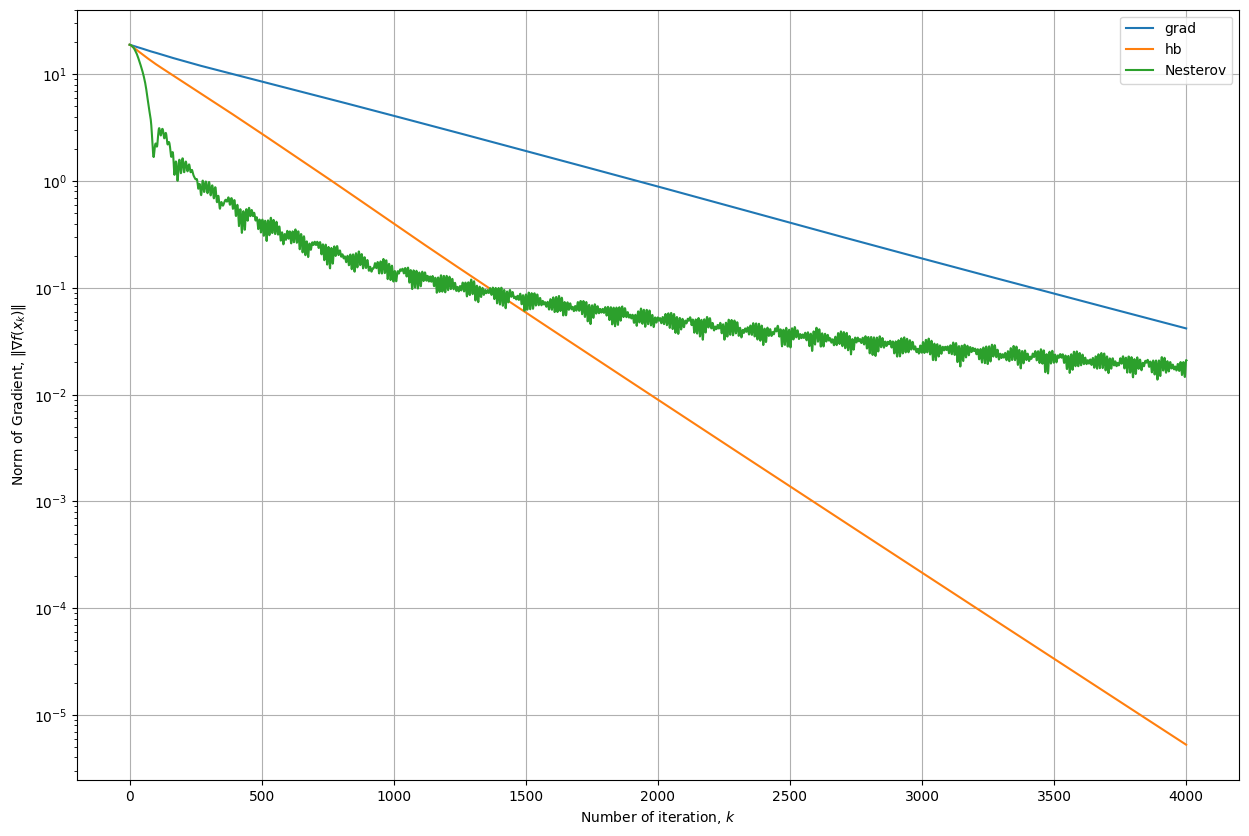

In [120]:
#Рисуем норму градиента
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot([np.linalg.norm(log_grad(X, y, i, coef = 1)) for i in conv_l],label = 'grad')
plt.plot([np.linalg.norm(log_grad(X, y, i, coef = 1)) for i in conv_hb_l],label = 'hb')
plt.plot([np.linalg.norm(log_grad(X, y, i, coef = 1)) for i in conv_n_l],label = 'Nesterov')
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.yscale('log')

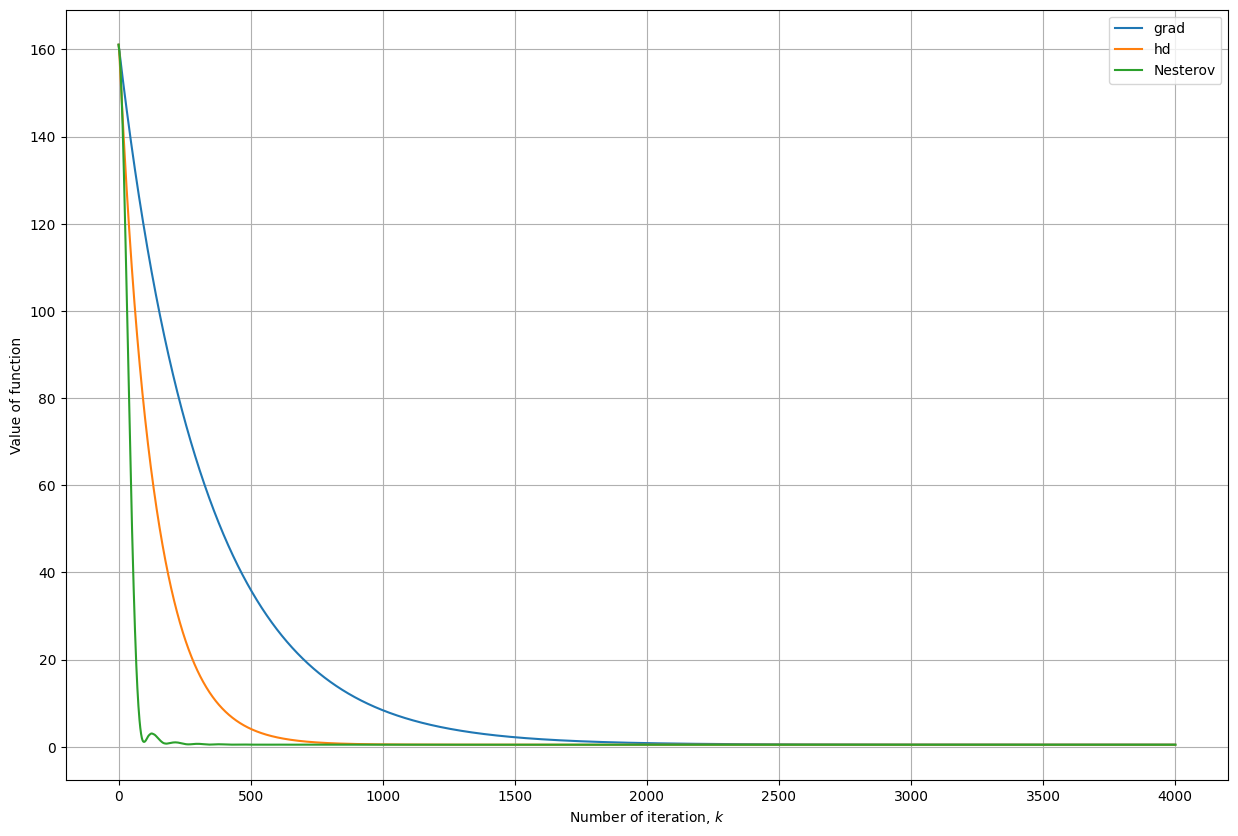

In [121]:
#Рисуем значение функции
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot([np.linalg.norm(logloss(X, y, i, coef = 1)) for i in conv_l],label = 'grad')
plt.plot([np.linalg.norm(logloss(X, y, i, coef = 1)) for i in conv_hb_l],label = 'hd')
plt.plot([np.linalg.norm(logloss(X, y, i, coef = 1)) for i in conv_n_l],label = 'Nesterov')
plt.grid()
plt.ylabel(r"Value of function")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

На самом деле $L = 1 + \frac{C}{4m}\sum_{i=1}^{m} {\|y_ix_i\|^2}$ - это именно верхняя оценка константы Липшица. Дело в том, что в нахождении оценки константы Липшица мы воспользовались неравенством Коши-Буняковского, но в некоторых $w_2$ и $w_1$ $|\langle x, w_2 - w_1 \rangle|$ может быть существенно меньше, чем $\|x\|\|w_2 - w_1\|$, если угол между векторами достаочно большой, поэтому шаг $\alpha = 1/L$ не всегда лучший. ПРоверим $\alpha=3/L$ 

In [111]:
#Запуск градиентного спуска
w_l, conv_l = gd_logloss(grad = log_grad, w0 = w0, num_iter = 4000, tol = 1e-10, alpha = 3/L, X = X, y = y, coef = 1)

In [112]:
#Запуск тяжелого шарика
w_hb_l, conv_hb_l = hb_logloss(grad = log_grad, w0 = w0, num_iter = 4000, tol = 1e-10, alpha = 3/L, beta = 0.6,X = X,y = y, coef = 1)

In [113]:
#Запуск Метода Нестерова
w_n_l, conv_n_l = Nesterov_logloss(grad = log_grad, w0 = w0, num_iter = 4000, tol = 1e-10, alpha = 3/L, X = X, y = y, coef = 1)

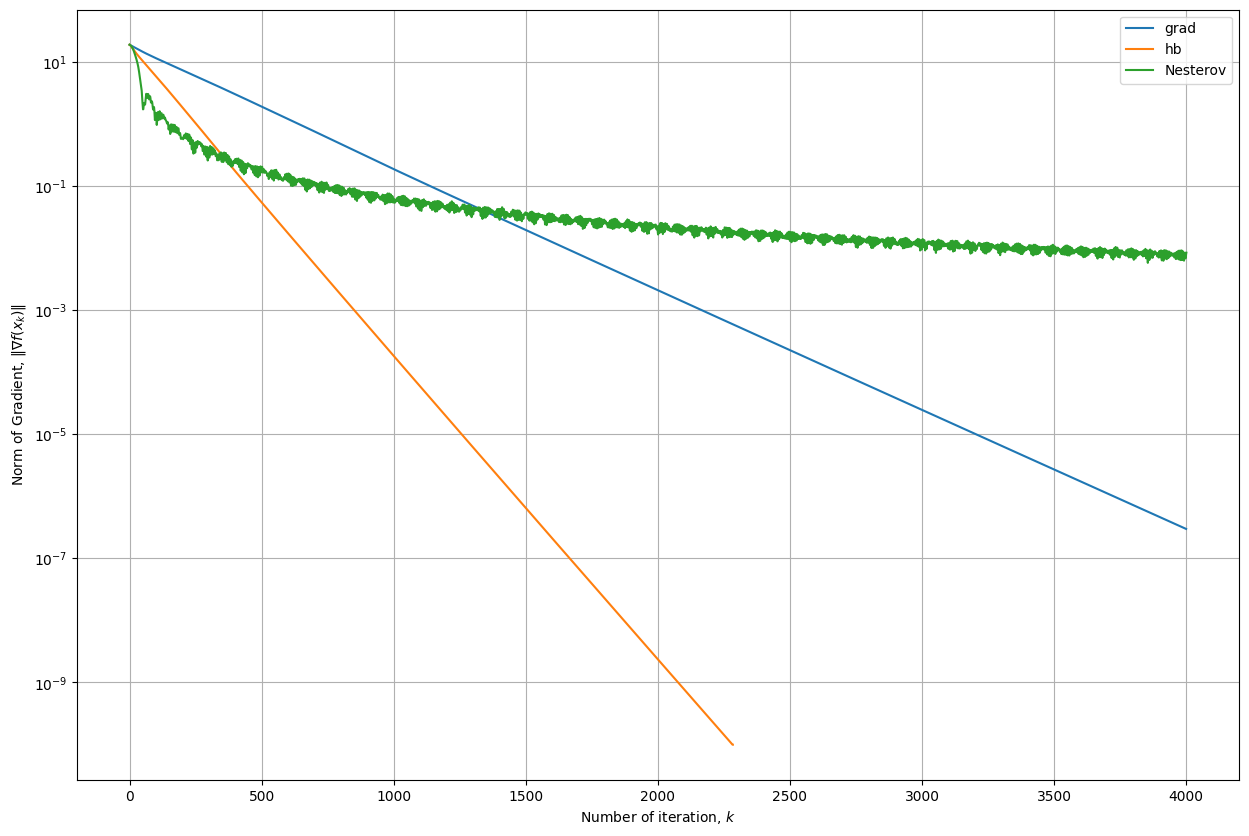

In [114]:
#Рисуем норму градиента
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot([np.linalg.norm(log_grad(X, y, i, coef = 1)) for i in conv_l],label = 'grad')
plt.plot([np.linalg.norm(log_grad(X, y, i, coef = 1)) for i in conv_hb_l],label = 'hb')
plt.plot([np.linalg.norm(log_grad(X, y, i, coef = 1)) for i in conv_n_l],label = 'Nesterov')
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.yscale('log')

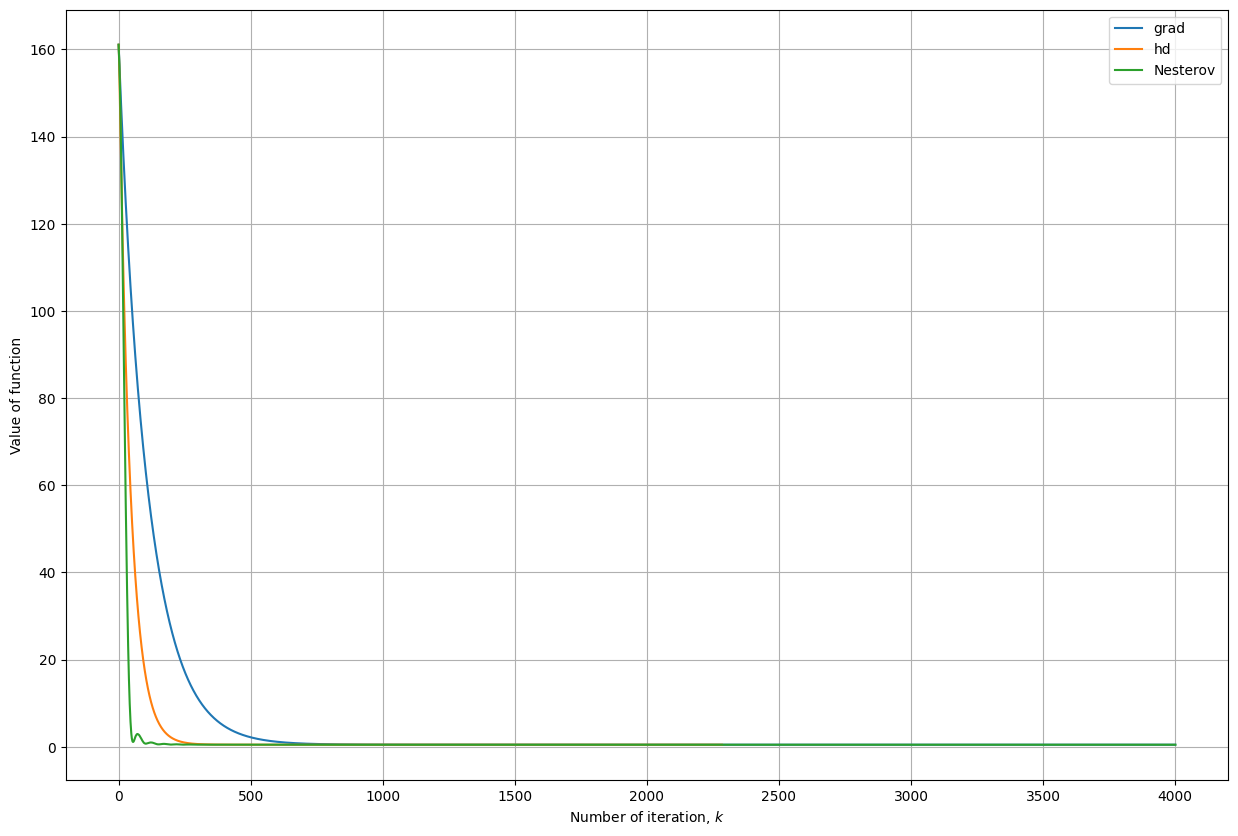

In [115]:
#Рисуем значение функции
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.plot([np.linalg.norm(logloss(X, y, i, coef = 1)) for i in conv_l],label = 'grad')
plt.plot([np.linalg.norm(logloss(X, y, i, coef = 1)) for i in conv_hb_l],label = 'hd')
plt.plot([np.linalg.norm(logloss(X, y, i, coef = 1)) for i in conv_n_l],label = 'Nesterov')
plt.grid()
plt.ylabel(r"Value of function")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

Как можно заметить, норма градиента при $\alpha = 3/L$ стремится к 0 быстрее, чем при $\alpha = 1/L$, это объясняется точностью константы Липшица